
SixHumpCamel: 2D


In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 56.3 MB/s 
     |████████████████████████████████| 872 kB 59.1 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=129ff6e3bb023b337495549ae68efd69525c68c495d828c4d9302cdcfd7bd189
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=2835d2bd0ef9a9d6e6b7bf4e69e0b5171cc4fec9f911598e2d3ae5305b24680e
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### 1. Import python modules/packages required:

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import itertools
import seaborn as sns
import time

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential
from joblib import Parallel, delayed
from scipy.linalg import inv
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'SixHumpCamel'
n_test = 500
eps = 1e-08

util_gp = 'CBM_gp'
util_stp = 'CBM_stp'

n_init = 5 # random initialisations
iters = 20
opt = True

df = 3

In [4]:
### Objective Function - SixHumpCamel(x) 2-D:

def objfunc(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    
# Constraints:
lb_x1 = -3
ub_x1 = +3
    
lb_x2 = -2
ub_x2 = +2

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_global_orig = -1.0316 # targets global minimum

# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test) 
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))

In [5]:
n_start_AcqFunc = iters
inverse = -1


In [6]:
### Cumulative Regret Calculators:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  
def acqFuncExact(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-2][::-3]
    return new_array[::-1]

def acqFuncApprox(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[:-1][::-3]
    return new_array[::-1]


In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds   

class dtStudentProcess(tStudentProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the STP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        
        smd_adj = (self.nu + self.beta1 - 2) / (self.nu + self.n1 - 2)

        alpha = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), self.y)
        alpha_Kstar = np.dot(np.linalg.inv(self.K11 + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)      
        
        dm = np.dot(dKstar, alpha)
        ds = -2 * smd_adj * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds 
        

In [8]:
### Add exact acquisition function gradient as attribute:

Beta_CBM = dim

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM_stp': self.CBM_stp,
            'CBM_gp': self.CBM_gp,
        }

        self.f = mode_dict[mode]
    
    def CBM_stp(self, y_global_orig, mean, std, ds, dm, nu=3.0):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_stp(self, tau, mean, std, ds, dm, nu=3.0):
    
        return self.f(tau, mean, std, ds, dm, nu=3.0, **self.params)

    def CBM_gp(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval_gp(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## dGPGO - Gaussian:

class dGPGO_gp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_gp(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [10]:
## dGPGO - Student's-t:

class dGPGO_stp(GPGO):
    n_start = n_start_AcqFunc

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        Exact CBM: StdDev. x \t Approx CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'

    def acqfuncExact(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f, -df
   
    def acqfuncApprox(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval_stp(self.tau, new_mean, new_std, ds=ds, dm=dm, nu=3.0)

        return -f

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std)

        x_best_gp = np.empty((n_start, len(self.parameter_key)))
        f_best_gp = np.empty((n_start,))
        opt_gp = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best_gp = np.array([res.x for res in opt_gp])
        f_best_gp = np.array([np.atleast_1d(res.fun)[0] for res in opt_gp])
        f_best_min_gp = min(f_best_gp)

        self.x_best_gp = x_best_gp
        self.f_best_gp = f_best_gp
        self.f_best_min_gp = f_best_min_gp
        self.x_best_std_gp = np.std(x_best_gp)
        self.best_gp = x_best_gp[np.argmin(f_best_gp)]
        self.start_points_arr = start_points_arr
        self.history.append(self.x_best_std_gp)
    
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        min_acqfunc_gp = str(self.f_best_min_gp)
        x_best_std = str(self.x_best_std)
        x_best_std_gp = str(self.x_best_std_gp)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            x_best_std_gp = BOLD + OKGREEN + x_best_std_gp + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, x_best_std, x_best_std_gp))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_gp = time.time()
start_gp


1663689243.3884788

In [13]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_gp_1 = dGaussianProcess(cov_func, optimize=opt)

gp_1 = dGPGO_gp(surrogate_gp_1, Acquisition_grad(util_gp), objfunc, param)
gp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.3492969   0.02371578]	 2.2990347824240986	 -0.2650082867644827	 1.780267227566921	 1.8723403745339924
2  	 [-0.2136461   1.85211599]	 33.12995854462853	 -0.2650082867644827	 1.2355747259233072	 1.442722378155366
3  	 [-1.08693075 -0.57968357]	 2.081871053435391	 -0.2650082867644827	 1.8590355198093715	 2.2139258205773094
4  	 [ 1.96269283 -1.93992408]	 41.08987834331432	 -0.2650082867644827	 1.8051736504234104	 2.1434907743213634
5  	 [3.         1.43216832]

In [14]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_gp_2 = dGaussianProcess(cov_func, optimize=opt)

gp_2 = dGPGO_gp(surrogate_gp_2, Acquisition_grad(util_gp), objfunc, param)
gp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.58911454  0.18307769]	 0.9117875623234453	 0.011939608840498828	 1.8687801931790096	 1.9863982629593389
2  	 [3. 2.]	 162.89999999999998	 0.011939608840498828	 1.5737000727450194	 1.9359617763878998
3  	 [ 2.9310582  -1.80452766]	 114.8309225225471	 0.011939608840498828	 1.7448453231707954	 2.0572850767718633
4  	 [0.25493407 2.        ]	 48.76105501974456	 0.011939608840498828	 1.8054239219274033	 1.9286692031659338
5  	 [-2.69105439 -0.30036879]	 45.9

In [15]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_gp_3 = dGaussianProcess(cov_func, optimize=opt)

gp_3 = dGPGO_gp(surrogate_gp_3, Acquisition_grad(util_gp), objfunc, param)
gp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.23849928  0.30167322]	 -0.18205256808335576	 -0.2431922946563294	 1.612648998938329	 1.5921389141990647
2  	 [-0.51362716  1.20463621]	 2.9152167171147307	 -0.2431922946563294	 1.6138888555743105	 1.6928510713579668
3	 [ 0.17474691 -0.57203629]	 -0.8603602623362779	 -0.8603602623362779	 1.5069830954804524	 1.8302401671016946
4  	 [-0.10150024 -0.25010819]	 -0.16819164660990865	 -0.8603602623362779	 1.396421601392308	 1.3103249634260725
5  	 [ 1.23774714 -1.804258

In [16]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_gp_4 = dGaussianProcess(cov_func, optimize=opt)

gp_4= dGPGO_gp(surrogate_gp_4, Acquisition_grad(util_gp), objfunc, param)
gp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [-0.17339693 -0.27765022]	 -0.11806697884384876	 -0.11806697884384876	 1.577257508311141	 2.0019383618452062
2	 [-0.00147108 -0.85065872]	 -0.7987158701996016	 -0.7987158701996016	 1.7772720012219083	 2.1204772234302043
3  	 [ 0.12497667 -1.35964772]	 6.167381400448541	 -0.7987158701996016	 2.096188063622335	 2.2211520412676506
4  	 [-0.57159007  1.97220857]	 44.92476325867485	 -0.7987158701996016	 1.9760583085217804	 2.281815164221442
5  	 [-3. -2.]	 162.89999999999998	 -0.

In [17]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_gp_5 = dGaussianProcess(cov_func, optimize=opt)

gp_5 = dGPGO_gp(surrogate_gp_5, Acquisition_grad(util_gp), objfunc, param)
gp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 1.9646927451771634	 2.257808012331222
2  	 [ 2.18426688 -2.        ]	 51.11435550621524	 -0.6512780061070701	 1.6754733512472832	 2.0725294342772678
3  	 [0.30614611 0.43079679]	 -0.11595942154317856	 -0.6512780061070701	 1.8403967749217847	 1.715069176062117
4  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 1.6875572276599162	 1.7429127272976337
5  	 [ 0.1169551  -0.01450732]	 0.051783549535876085	 -0.65127800

In [18]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_gp_6 = dGaussianProcess(cov_func, optimize=opt)

gp_6 = dGPGO_gp(surrogate_gp_6, Acquisition_grad(util_gp), objfunc, param)
gp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.24464431 1.10063748]	 1.525593209097275	 -0.3096187466378422	 2.0348476733877763	 1.679911753812162
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 2.2496400552647278	 2.1743910594329834
3  	 [-1.27129541 -2.        ]	 52.92920375159655	 -0.3096187466378422	 1.4947486539657213	 1.730056118085053
4	 [-0.10002854  0.58601899]	 -0.9207343254100167	 -0.9207343254100167	 1.5889038211407978	 1.7878611995677764
5	 [-0.1716657   0.68810682]	 -0.99925214994139

In [19]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_gp_7 = dGaussianProcess(cov_func, optimize=opt)

gp_7 = dGPGO_gp(surrogate_gp_7, Acquisition_grad(util_gp), objfunc, param)
gp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.24433539 1.62470675]	 17.941144492451414	 -0.46481072558790276	 2.0747857390452666	 1.9729968538674647
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 1.476826716896781	 1.476826716896781
3  	 [-0.24231377  0.39615082]	 -0.3975282635280166	 -0.46481072558790276	 2.025368902292496	 2.11401995966366
4  	 [-0.7036138   0.70467404]	 0.010262185090887499	 -0.46481072558790276	 1.809399426034037	 2.0163998844175186
5  	 [-3. -2.]	 

In [20]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_gp_8 = dGaussianProcess(cov_func, optimize=opt)

gp_8 = dGPGO_gp(surrogate_gp_8, Acquisition_grad(util_gp), objfunc, param)
gp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1	 [-0.68775101  0.76707475]	 -0.03884863494451185	 -0.03884863494451185	 1.3696758460478275	 1.6744929304933691
2  	 [-2.08673122  1.9823609 ]	 47.03732591347165	 -0.03884863494451185	 1.3897239821267027	 2.549019419306177
3	 [-0.19938997  0.33683148]	 -0.3137668447235813	 -0.3137668447235813	 1.369035175881427	 1.6735798325739466
4  	 [-0.15577756  0.27562452]	 -0.22789179772507512	 -0.3137668447235813	 1.6854018860007698	 2.05842648265736
5  	 [ 1.83113499 -2.        ]	

In [21]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_gp_9 = dGaussianProcess(cov_func, optimize=opt)

gp_9 = dGPGO_gp(surrogate_gp_9, Acquisition_grad(util_gp), objfunc, param)
gp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.29955841 2.        ]	 48.941388594047986	 1.395407492769129	 1.486286346663899	 1.4924231086599675
2  	 [3.         0.35932676]	 109.52820087466705	 1.395407492769129	 2.2871568014080794	 2.345673634388984
3  	 [ 1.67984783 -1.82952546]	 30.40745651033678	 1.395407492769129	 2.110261964326252	 2.1194153883467726
4  	 [-2.29310262 -1.99370325]	 63.302653577289135	 1.395407492769129	 1.8902981850110896	 1.599691724875898
5	 [-0.52391154 -0.43425741]	 0.5620535946762305	 0.562

In [22]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_gp_10 = dGaussianProcess(cov_func, optimize=opt)

gp_10 = dGPGO_gp(surrogate_gp_10, Acquisition_grad(util_gp), objfunc, param)
gp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.6978547490176488	 1.8517943387224822
2  	 [-2.52977022  2.        ]	 69.90104466534092	 0.7775687473184012	 1.4205459874112363	 2.0144208999480853
3  	 [-0.92238143  0.28247441]	 1.534115758095715	 0.7775687473184012	 1.4508055632697263	 1.8864547212543379
4  	 [ 3.         -0.28436045]	 107.74962908301715	 0.7775687473184012	 1.5852604953676643	 2.0289077518603698
5	 [-0.30063401  0.79704973]	 -0.8217935151595995	 -0.82

In [23]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_gp_11 = dGaussianProcess(cov_func, optimize=opt)

gp_11 = dGPGO_gp(surrogate_gp_11, Acquisition_grad(util_gp), objfunc, param)
gp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.47476349 -1.92846544]	 39.79869198083824	 -0.6254688257880329	 1.4461746731163707	 1.8693091717553907
2  	 [-0.2544476   1.37526174]	 6.643692218711133	 -0.6254688257880329	 0.5721959927140209	 1.5081968990474663
3  	 [0.07709142 0.13761216]	 -0.040007010729497666	 -0.6254688257880329	 1.6610121996446212	 2.0391575476721724
4  	 [-0.03226158  0.31219214]	 -0.3577696984352794	 -0.6254688257880329	 1.3175735673972333	 1.9518990262580445
5  	 [-0.01588006  0.28029

In [24]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_gp_12 = dGaussianProcess(cov_func, optimize=opt)

gp_12 = dGPGO_gp(surrogate_gp_12, Acquisition_grad(util_gp), objfunc, param)
gp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.01073947  0.89326961]	 0.7022868629767492	 0.7022868629767492	 2.3249912681053466	 1.8981031254508887
2  	 [2.02754203 2.        ]	 56.16721679988096	 0.7022868629767492	 2.2688476103958712	 1.9326324191639614
3  	 [-3. -2.]	 162.89999999999998	 0.7022868629767492	 1.6974702649429443	 1.8174286558014907
4  	 [-0.1629937 -2.       ]	 48.430779236440586	 0.7022868629767492	 1.2233326086077876	 1.2519250324062297
5  	 [-0.29100599  1.9689627 ]	 44.36239422891152	 0.7022

In [25]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_gp_13 = dGaussianProcess(cov_func, optimize=opt)

gp_13 = dGPGO_gp(surrogate_gp_13, Acquisition_grad(util_gp), objfunc, param)
gp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.48289376 -1.25472261]	 3.833614795087552	 0.752930921147986	 1.082369842407008	 1.1136119066491539
2  	 [-0.85258431  1.2964394 ]	 5.397428556554959	 0.752930921147986	 1.1411004997568457	 1.4212471734688892
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 0.863847596348414	 1.7609573910324228
4  	 [ 1.04147281 -1.87501493]	 35.71793326777267	 0.752930921147986	 1.4748281299622479	 2.118832451288732
5  	 [-2.64593551  0.33674786]	 38.16316952279075	 0.752930921147986	 1.864

In [26]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_gp_14 = dGaussianProcess(cov_func, optimize=opt)

gp_14 = dGPGO_gp(surrogate_gp_14, Acquisition_grad(util_gp), objfunc, param)
gp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 1.503658355512916	 1.503658355512916
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 1.5374298505922563	 1.5374298505922563
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 1.3235846389965387	 1.3235846389965387
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 1.4304797833357905	 1.4304797833357905
5  	 [ 0.03780031 -0.50077993]	 -0.7647

In [27]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_gp_15 = dGaussianProcess(cov_func, optimize=opt)

gp_15 = dGPGO_gp(surrogate_gp_15, Acquisition_grad(util_gp), objfunc, param)
gp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1  	 [-0.08986902  1.21623266]	 2.758369274324555	 2.1163170846379233	 1.8791381159377298	 1.459051555562823
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 1.8110631017233254	 2.1654888512553345
3  	 [-2.06279418  2.        ]	 48.553326967511815	 2.1163170846379233	 1.4857932123488218	 1.7312901558769576
4  	 [-0.23497557 -2.        ]	 48.68445938627404	 2.1163170846379233	 1.237573058453135	 1.53924573151077
5  	 [1.01885424 0.19797735]	 2.313284079409903	 2.11631708

In [28]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_gp_16 = dGaussianProcess(cov_func, optimize=opt)

gp_16 = dGPGO_gp(surrogate_gp_16, Acquisition_grad(util_gp), objfunc, param)
gp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.01480441]	 108.85471029509407	 1.8632773736203017	 1.9647233104604698	 2.1764904283952635
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.2649637976531602	 2.096264122463221
3  	 [0.52821838 2.        ]	 50.016252473070985	 1.8632773736203017	 1.727798497172888	 1.634861444933043
4  	 [-0.96259387  0.01935316]	 2.148415732612292	 1.8632773736203017	 1.3892142081917693	 1.9621112101190437
5  	 [-0.89764558 -0.09748804]	 2.0838613238424473	 1.863

In [29]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_gp_17 = dGaussianProcess(cov_func, optimize=opt)

gp_17 = dGPGO_gp(surrogate_gp_17, Acquisition_grad(util_gp), objfunc, param)
gp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [ 2.6434919 -2.       ]	 81.86501499426166	 1.7722768782964888	 1.5853617645971152	 1.8913609166986456
2  	 [-0.59781661  1.25180255]	 3.982224090571259	 1.7722768782964888	 1.6486118213446284	 1.796837941919022
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.9826231471105253	 1.8367687559406598
4  	 [0.99990597 0.14174647]	 2.2961625092695823	 1.7722768782964888	 1.6003371609378634	 1.8289202306677441
5  	 [-1.4315266  1.9950458]	 46.83817921025394	 1.7722768782964

In [30]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_gp_18 = dGaussianProcess(cov_func, optimize=opt)

gp_18 = dGPGO_gp(surrogate_gp_18, Acquisition_grad(util_gp), objfunc, param)
gp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-2.66531469  1.40819616]	 45.98276773059287	 2.062169771852028	 1.6802077690565969	 2.1035042229056096
2	 [ 0.57044416 -0.50079564]	 0.053478115527239245	 0.053478115527239245	 2.024313414480791	 1.9505898678200055
3	 [ 0.55004011 -0.54515731]	 -0.1081531153195423	 -0.1081531153195423	 1.9029362699720287	 1.9648435806404574
4	 [ 0.54396207 -0.55439646]	 -0.14477118692473945	 -0.14477118692473945	 2.2180365832608	 2.166779253794443
5	 [ 0.55295628 -0.57489648]	 -0.16673673682655443	 

In [31]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_gp_19 = dGaussianProcess(cov_func, optimize=opt)

gp_19 = dGPGO_gp(surrogate_gp_19, Acquisition_grad(util_gp), objfunc, param)
gp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [ 1.26640182 -1.82333111]	 30.99167463723061	 6.578088852480828	 1.8636079663511735	 2.0942692753112264
2  	 [0.21328351 1.88435368]	 36.808795354286346	 6.578088852480828	 1.9782858917178014	 2.2690316224505267
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 1.323800931682913	 1.9329666255722635
4	 [-0.69985661 -0.06881836]	 1.5238771033360046	 1.5238771033360046	 1.5779816141181857	 1.9935341563375764
5	 [-0.40151976 -0.13578571]	 0.5738169638574423	 0.5738169638574423

In [32]:
### EXACT GP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_gp_20 = dGaussianProcess(cov_func, optimize=opt)

gp_20 = dGPGO_gp(surrogate_gp_20, Acquisition_grad(util_gp), objfunc, param)
gp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.18260098 -2.        ]	 52.7637507573476	 1.5037392797834441	 1.8477976467762007	 1.8425155824679174
2  	 [ 2.61526506 -1.63013479]	 49.12605456771107	 1.5037392797834441	 1.6828012712835971	 2.340853856877409
3	 [ 0.24789639 -0.18292768]	 0.0632390460951128	 0.0632390460951128	 2.277076360170087	 1.6588166564374507
4	 [-0.25048442  0.20970414]	 0.02208978039756121	 0.02208978039756121	 2.023017473402835	 1.6392758841375008
5	 [ 0.106724   -0.06694389]	 0.020297982920309

In [33]:
end_gp = time.time()
end_gp

time_gp = end_gp - start_gp
time_gp

start_stp = time.time()
start_stp

1663689709.951111

In [34]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_1)
surrogate_stp_1 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_1 = dGPGO_stp(surrogate_stp_1, Acquisition_grad(util_stp), objfunc, param)
stp_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [1.79042321 2.        ]	 53.804040058429514	 -0.2650082867644827	 1.726220283547533	 2.0895252715105435
2  	 [ 1.20864301 -1.67793054]	 20.818250533397155	 -0.2650082867644827	 1.5052560207009573	 2.3739121210188063
3  	 [-1.60215436  1.22842078]	 3.17284516692596	 -0.2650082867644827	 1.832427728665422	 2.217300918282091
4  	 [-2.87085117  1.79188084]	 100.1840744807586	 -0.2650082867644827	 1.613668698603838	 2.10203386557251
5  	 [ 2.91861002 -0.2714603 ]	 86

In [35]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_2)
surrogate_stp_2 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_2 = dGPGO_stp(surrogate_stp_2, Acquisition_grad(util_stp), objfunc, param)
stp_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [3. 2.]	 162.89999999999998	 0.011939608840498828	 1.8408727534197826	 2.3551992375524984
2  	 [ 2.76552382 -1.62083546]	 69.49395462832902	 0.011939608840498828	 1.6824528680937416	 2.254154082545944
3  	 [-0.29530445  1.80279752]	 29.052431423543702	 0.011939608840498828	 1.7151502124477422	 2.112486566560711
4  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 1.4623912652153654	 1.7409457516141837
5  	 [-2.47572493  0.86292235]	 19.481227124439183	

In [36]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_3)
surrogate_stp_3 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_3 = dGPGO_stp(surrogate_stp_3, Acquisition_grad(util_stp), objfunc, param)
stp_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [ 0.38902174 -1.26039243]	 3.8081951208326714	 -0.2431922946563294	 1.789118891955185	 1.8753569353668613
2  	 [-0.56859321  2.        ]	 47.94777475581011	 -0.2431922946563294	 1.6008938329544666	 2.2078596190959785
3  	 [ 2.14712765 -0.86354038]	 3.856255829442631	 -0.2431922946563294	 1.6370128262362378	 2.318691412276592
4  	 [-1.05432442 -2.        ]	 52.41802544288639	 -0.2431922946563294	 1.5654063998828383	 2.031703973701045
5  	 [ 0.79593465 -0.13722771]	 1.

In [37]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_4)
surrogate_stp_4 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_4 = dGPGO_stp(surrogate_stp_4, Acquisition_grad(util_stp), objfunc, param)
stp_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1  	 [-0.72364147  2.        ]	 48.1193551923554	 2.3196402150601703	 1.5854744539040673	 2.1826803203359786
2  	 [-3. -2.]	 162.89999999999998	 2.3196402150601703	 1.7468027347355493	 1.5324643830180493
3  	 [-0.21760271 -1.98389268]	 46.83614658444274	 2.3196402150601703	 1.5339893894674042	 2.199191981181622
4	 [0.13843063 0.24478989]	 -0.11555597090403094	 -0.11555597090403094	 1.3082749027916207	 1.9295875004229268
5  	 [-2.94054987  1.08640518]	 90.73294807580693	 -0.1155

In [38]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_5)
surrogate_stp_5 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_5 = dGPGO_stp(surrogate_stp_5, Acquisition_grad(util_stp), objfunc, param)
stp_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 2.1509547071672204	 2.336585419601019
2  	 [ 1.80285852 -1.91843449]	 38.2626097222265	 -0.6512780061070701	 1.8404618207400625	 2.0666207085812816
3  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 1.9837334439627408	 2.1966066902850594
4  	 [ 0.07603746 -0.95009895]	 -0.40055590460043705	 -0.6512780061070701	 1.0012077192822573	 1.9251653708981546
5  	 [-2.16231855  0.16168345]	 6.413959804325772	 -0.651278006

In [39]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_6)
surrogate_stp_6 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_6 = dGPGO_stp(surrogate_stp_6, Acquisition_grad(util_stp), objfunc, param)
stp_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.60454306 2.        ]	 50.40675037480955	 -0.3096187466378422	 2.1177471496151687	 2.049816421407928
2  	 [-1.79818127 -2.        ]	 53.84303759459686	 -0.3096187466378422	 2.221281441796386	 2.105001241146364
3  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 1.9204702272222016	 2.375026686135106
4  	 [-1.70805801  1.72097302]	 22.374222241265805	 -0.3096187466378422	 1.6425370046560495	 2.2726237240421514
5  	 [ 0.0609619  -1.38870959]	 7.09279091146843

In [40]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_7)
surrogate_stp_7 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_7 = dGPGO_stp(surrogate_stp_7, Acquisition_grad(util_stp), objfunc, param)
stp_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [-3. -2.]	 162.89999999999998	 -0.46481072558790276	 2.201053744970679	 2.079134159968371
2  	 [0.86724197 2.        ]	 51.69683137248224	 -0.46481072558790276	 1.2002129397711725	 2.0164820315178944
3  	 [ 1.96812024 -1.92847676]	 40.01120793667761	 -0.46481072558790276	 1.6340200021365627	 1.9356538195968194
4  	 [0.35761444 0.17159428]	 0.4249574566174419	 -0.46481072558790276	 1.4859311098238495	 1.749494614859428
5  	 [-0.97779432  1.94087862]	 41

In [41]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_8)
surrogate_stp_8 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_8 = dGPGO_stp(surrogate_stp_8, Acquisition_grad(util_stp), objfunc, param)
stp_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1  	 [-1.62175844  1.70055452]	 21.184892336767497	 0.03190064766213015	 1.4167742764210567	 2.0727856678897707
2  	 [ 1.95656727 -2.        ]	 47.324712823851435	 0.03190064766213015	 1.621299576132665	 2.2415823552515475
3	 [0.17287461 0.88343524]	 -0.41497428856186963	 -0.41497428856186963	 1.2595390871161067	 1.7578681010482042
4  	 [-2.24055334 -0.13301277]	 9.556977310828824	 -0.41497428856186963	 1.7675706283224102	 2.0733026704230344
5  	 [0.15008167 1.74742576]	 2

In [42]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_9)
surrogate_stp_9 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_9 = dGPGO_stp(surrogate_stp_9, Acquisition_grad(util_stp), objfunc, param)
stp_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [3. 2.]	 162.89999999999998	 1.395407492769129	 1.5811388300841898	 1.515750639122412
2  	 [-0.39127315  2.        ]	 47.78180873109559	 1.395407492769129	 1.6336473725443361	 2.0107780183455737
3  	 [ 2.48693791 -1.50711775]	 31.074690591872464	 1.395407492769129	 1.647684238813063	 2.4894778569009204
4  	 [-3. -2.]	 162.89999999999998	 1.395407492769129	 1.524284736297687	 1.6656012901656476
5  	 [0.88595844 0.06539918]	 2.0479765233169664	 1.395407492769129	 1.1595299511474

In [43]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_10)
surrogate_stp_10 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_10 = dGPGO_stp(surrogate_stp_10, Acquisition_grad(util_stp), objfunc, param)
stp_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.697205033951785	 2.15224899510449
2  	 [-2.61449364  1.91527658]	 69.82856476776364	 0.7775687473184012	 1.4047530890184192	 2.002267519723358
3	 [-0.6654973   0.53935853]	 0.20452860587745303	 0.20452860587745303	 1.3871056237558312	 1.9564461696289315
4  	 [-0.20105965  1.70768151]	 22.166572933237113	 0.20452860587745303	 1.7624279391239221	 1.9915707266031162
5  	 [-2.96886182 -0.29545961]	 100.92211838108385	 0.2045

In [44]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_11)
surrogate_stp_11 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_11 = dGPGO_stp(surrogate_stp_11, Acquisition_grad(util_stp), objfunc, param)
stp_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.53288764 -1.99098116]	 46.07419650466159	 -0.6254688257880329	 1.4991345998191186	 2.2477894319433807
2  	 [0.37866484 1.66691415]	 20.930679556934187	 -0.6254688257880329	 0.8856934262205853	 1.6055352161205731
3  	 [-1.1305015   1.71048727]	 22.981559587495894	 -0.6254688257880329	 1.6748838630973524	 2.1095498092632377
4  	 [ 0.54010831 -0.05033853]	 0.9591369398356522	 -0.6254688257880329	 1.381614067266164	 1.9158208522062636
5  	 [-0.19761748 -0.47056646]

In [45]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_12)
surrogate_stp_12 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_12 = dGPGO_stp(surrogate_stp_12, Acquisition_grad(util_stp), objfunc, param)
stp_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1  	 [1.38030649 2.        ]	 53.063999837195766	 1.9967735906956543	 2.3606455146862304	 1.8919575006018479
2  	 [-3. -2.]	 162.89999999999998	 1.9967735906956543	 2.2002888693306257	 2.0158619571371
3  	 [-0.03248235 -2.        ]	 48.069182773984295	 1.9967735906956543	 1.5237314932126165	 1.6645447766675694
4	 [-0.41703752  1.06768615]	 0.8268112897374242	 0.8268112897374242	 1.4545359154883586	 1.2929315042525122
5	 [0.39289274 0.02388719]	 0.5757491655614791	 0.5757491

In [46]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_13)
surrogate_stp_13 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_13 = dGPGO_stp(surrogate_stp_13, Acquisition_grad(util_stp), objfunc, param)
stp_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.13675952 -1.49937764]	 11.092906130192734	 0.752930921147986	 1.0664688396990043	 0.5432620482863644
2  	 [-1.92461341  1.34390885]	 6.181244555686899	 0.752930921147986	 1.026908922908201	 1.6564670824369778
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 0.5	 1.8402184208609567
4  	 [-0.52567592  2.        ]	 47.900664237135345	 0.752930921147986	 1.3293369458958724	 1.9816379646499116
5	 [-0.2416184  -0.04700755]	 0.22896556771359755	 0.22896556771359755	 1.770751176265

In [47]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_14)
surrogate_stp_14 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_14 = dGPGO_stp(surrogate_stp_14, Acquisition_grad(util_stp), objfunc, param)
stp_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [2.55903938 1.63587217]	 51.877186915700115	 -1.029299726828387	 2.2913173659293906	 1.906763416483274
2  	 [-1.96678135 -2.        ]	 55.2774567021992	 -1.029299726828387	 1.654553778933135	 1.5872821497106224
3  	 [-2.62038556  0.28589381]	 35.318125044471785	 -1.029299726828387	 1.3222326389966637	 1.6295264187895442
4  	 [0.77226543 0.12066405]	 1.745138610512579	 -1.029299726828387	 1.3605904717501944	 1.779012817566801
5  	 [-0.25118283 -0.00910103]	 0.246050242337

In [48]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_15)
surrogate_stp_15 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_15 = dGPGO_stp(surrogate_stp_15, Acquisition_grad(util_stp), objfunc, param)
stp_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1	 [0.22647132 0.66251015]	 -0.6353594740740651	 -0.6353594740740651	 1.8706219180065893	 1.761930828629362
2  	 [-0.97929904  2.        ]	 48.24008691042726	 -0.6353594740740651	 1.5964569803054747	 2.0412653609208724
3  	 [2.30745827 1.31982539]	 20.293158463457104	 -0.6353594740740651	 2.0752483586989516	 1.9757699491673144
4	 [ 0.21144486 -0.70853983]	 -0.9751328045320621	 -0.9751328045320621	 1.9547257749739695	 2.0037046470581803
5  	 [-0.87923218 -2.        ]	 51.7496

In [49]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_16)
surrogate_stp_16 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_16 = dGPGO_stp(surrogate_stp_16, Acquisition_grad(util_stp), objfunc, param)
stp_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [3.         0.85782925]	 110.69602827579652	 1.8632773736203017	 2.1577807438933285	 2.2828939033035143
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 1.9128212421959234	 2.0629673618076083
3  	 [0.25612525 1.88060269]	 36.620500507609016	 1.8632773736203017	 1.352779000604869	 1.742352650936818
4	 [-0.17775045  0.15490859]	 0.0030766686536336935	 0.0030766686536336935	 1.213111845694942	 1.4470928214515786
5  	 [ 0.9003624 -0.1037965]	 1.9040696643850754	 0.00

In [50]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_17)
surrogate_stp_17 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_17 = dGPGO_stp(surrogate_stp_17, Acquisition_grad(util_stp), objfunc, param)
stp_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [-0.61261161  2.        ]	 47.99779394322794	 1.7722768782964888	 1.6187760224629186	 1.9616666636866302
2  	 [ 2.16747806 -2.        ]	 50.67077466992393	 1.7722768782964888	 1.8499853881982822	 2.4515301344262523
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.8946859896237855	 2.101648561091382
4	 [-0.01876883 -0.9279178 ]	 -0.4598004200826516	 -0.4598004200826516	 1.6524214397778085	 2.2166919366231044
5  	 [-0.10498632 -1.97912189]	 45.953078006727246	 -0.45980

In [51]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_18)
surrogate_stp_18 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_18 = dGPGO_stp(surrogate_stp_18, Acquisition_grad(util_stp), objfunc, param)
stp_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-2.69004771  1.38346314]	 48.56515358746992	 2.062169771852028	 1.792797731886961	 2.3585555376685474
2  	 [ 0.68464728 -1.99991873]	 48.06954728764297	 2.062169771852028	 2.01777950127421	 2.0338061059947967
3  	 [3. 2.]	 162.89999999999998	 2.062169771852028	 1.890652551283311	 2.1000688744466327
4	 [-0.7116824   0.40854004]	 0.6836152272459154	 0.6836152272459154	 1.7332668000115925	 1.9683803581130916
5  	 [-3. -2.]	 162.89999999999998	 0.6836152272459154	 1.5685381972102006	 2.

In [52]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_19)
surrogate_stp_19 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_19 = dGPGO_stp(surrogate_stp_19, Acquisition_grad(util_stp), objfunc, param)
stp_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [ 1.26640182 -1.82333111]	 30.99167463723061	 6.578088852480828	 1.9357826877798945	 2.141610150771833
2  	 [-0.1890062   1.85585008]	 33.46223405657863	 6.578088852480828	 1.93511581896053	 2.322917879123823
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 2.1601262751725376	 2.001877219361722
4	 [-0.2003543  -0.07967001]	 0.14793921243985209	 0.14793921243985209	 1.6139186482360537	 2.03092823868324
5  	 [-1.20852704  0.19257146]	 2.025456191217976	 0.14793921243985209	

In [53]:
### EXACT STP CBM GRADIENTS

np.random.seed(run_num_20)
surrogate_stp_20 = dtStudentProcess(cov_func, optimize=opt, nu = df)

stp_20 = dGPGO_stp(surrogate_stp_20, Acquisition_grad(util_stp), objfunc, param)
stp_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        Exact CBM: StdDev. x 	 Approx CBM: StdDev. x 
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.30896072 -1.98274556]	 51.055316282937284	 1.5037392797834441	 1.7619765835675871	 1.986119121441591
2  	 [ 3.         -1.20815418]	 107.95914645781573	 1.5037392797834441	 1.7339458591540828	 2.3361296728176155
3	 [ 0.41081037 -0.07958219]	 0.5589853155586734	 0.5589853155586734	 2.145105041826054	 2.010341146384665
4  	 [-3. -2.]	 162.89999999999998	 0.5589853155586734	 1.9085728184471795	 2.100946842792191
5  	 [-0.83352456  1.83581708]	 32.29973031794097	 0.55898531

In [54]:
end_stp = time.time()
end_stp

time_stp = end_stp - start_stp
time_stp


522.5051748752594

In [55]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.min(-gp_1.GP.y[0:n_init]),-gp_1.GP.y[n_init:(n_init+iters)]) 
stp_output_1 = np.append(np.min(-stp_1.GP.y[0:n_init]),-stp_1.GP.y[n_init:(n_init+iters)]) 

regret_gp_1 = np.log(gp_output_1 - y_global_orig)
regret_stp_1 = np.log(stp_output_1 - y_global_orig)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-0.2658009358573259, -0.2658009358573259)

In [56]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.min(-gp_2.GP.y[0:n_init]),-gp_2.GP.y[n_init:(n_init+iters)]) 
stp_output_2 = np.append(np.min(-stp_2.GP.y[0:n_init]),-stp_2.GP.y[n_init:(n_init+iters)]) 

regret_gp_2 = np.log(gp_output_2 - y_global_orig)
regret_stp_2 = np.log(stp_output_2 - y_global_orig)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(-0.37033831477837886, -0.46851043731158987)

In [57]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.min(-gp_3.GP.y[0:n_init]),-gp_3.GP.y[n_init:(n_init+iters)]) 
stp_output_3 = np.append(np.min(-stp_3.GP.y[0:n_init]),-stp_3.GP.y[n_init:(n_init+iters)]) 

regret_gp_3 = np.log(gp_output_3 - y_global_orig)
regret_stp_3 = np.log(stp_output_3 - y_global_orig)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3

(-1.7646907296866976, -0.23773993035753282)

In [58]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.min(-gp_4.GP.y[0:n_init]),-gp_4.GP.y[n_init:(n_init+iters)]) 
stp_output_4 = np.append(np.min(-stp_4.GP.y[0:n_init]),-stp_4.GP.y[n_init:(n_init+iters)]) 

regret_gp_4 = np.log(gp_output_4 - y_global_orig)
regret_stp_4 = np.log(stp_output_4 - y_global_orig)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4

(-2.288003773761189, -0.4029978249134022)

In [59]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.min(-gp_5.GP.y[0:n_init]),-gp_5.GP.y[n_init:(n_init+iters)]) 
stp_output_5 = np.append(np.min(-stp_5.GP.y[0:n_init]),-stp_5.GP.y[n_init:(n_init+iters)]) 

regret_gp_5 = np.log(gp_output_5 - y_global_orig)
regret_stp_5 = np.log(stp_output_5 - y_global_orig)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5

(-0.9667370327122197, -0.9667370327122197)

In [60]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.min(-gp_6.GP.y[0:n_init]),-gp_6.GP.y[n_init:(n_init+iters)]) 
stp_output_6 = np.append(np.min(-stp_6.GP.y[0:n_init]),-stp_6.GP.y[n_init:(n_init+iters)]) 

regret_gp_6 = np.log(gp_output_6 - y_global_orig)
regret_stp_6 = np.log(stp_output_6 - y_global_orig)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6

(-3.4312077190195, -2.2211643161957935)

In [61]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.min(-gp_7.GP.y[0:n_init]),-gp_7.GP.y[n_init:(n_init+iters)]) 
stp_output_7 = np.append(np.min(-stp_7.GP.y[0:n_init]),-stp_7.GP.y[n_init:(n_init+iters)]) 

regret_gp_7 = np.log(gp_output_7 - y_global_orig)
regret_stp_7 = np.log(stp_output_7 - y_global_orig)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7

(-0.567767694400235, -0.567767694400235)

In [62]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.min(-gp_8.GP.y[0:n_init]),-gp_8.GP.y[n_init:(n_init+iters)]) 
stp_output_8 = np.append(np.min(-stp_8.GP.y[0:n_init]),-stp_8.GP.y[n_init:(n_init+iters)]) 

regret_gp_8 = np.log(gp_output_8 - y_global_orig)
regret_stp_8 = np.log(stp_output_8 - y_global_orig)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8

(-0.3315181112038223, -0.4834930656674888)

In [63]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.min(-gp_9.GP.y[0:n_init]),-gp_9.GP.y[n_init:(n_init+iters)]) 
stp_output_9 = np.append(np.min(-stp_9.GP.y[0:n_init]),-stp_9.GP.y[n_init:(n_init+iters)]) 

regret_gp_9 = np.log(gp_output_9 - y_global_orig)
regret_stp_9 = np.log(stp_output_9 - y_global_orig)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9

(-0.9064052430357838, -0.9515469666252742)

In [64]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.min(-gp_10.GP.y[0:n_init]),-gp_10.GP.y[n_init:(n_init+iters)]) 
stp_output_10 = np.append(np.min(-stp_10.GP.y[0:n_init]),-stp_10.GP.y[n_init:(n_init+iters)]) 

regret_gp_10 = np.log(gp_output_10 - y_global_orig)
regret_stp_10 = np.log(stp_output_10 - y_global_orig)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10

(-2.179131198964215, -2.0435773838355433)

In [65]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.min(-gp_11.GP.y[0:n_init]),-gp_11.GP.y[n_init:(n_init+iters)]) 
stp_output_11 = np.append(np.min(-stp_11.GP.y[0:n_init]),-stp_11.GP.y[n_init:(n_init+iters)]) 

regret_gp_11 = np.log(gp_output_11 - y_global_orig)
regret_stp_11 = np.log(stp_output_11 - y_global_orig)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11

(-1.0436210177866634, -2.581580094718622)

In [66]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.min(-gp_12.GP.y[0:n_init]),-gp_12.GP.y[n_init:(n_init+iters)]) 
stp_output_12 = np.append(np.min(-stp_12.GP.y[0:n_init]),-stp_12.GP.y[n_init:(n_init+iters)]) 

regret_gp_12 = np.log(gp_output_12 - y_global_orig)
regret_stp_12 = np.log(stp_output_12 - y_global_orig)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12

(0.5503656299648695, -0.19228277939074592)

In [67]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.min(-gp_13.GP.y[0:n_init]),-gp_13.GP.y[n_init:(n_init+iters)]) 
stp_output_13 = np.append(np.min(-stp_13.GP.y[0:n_init]),-stp_13.GP.y[n_init:(n_init+iters)]) 

regret_gp_13 = np.log(gp_output_13 - y_global_orig)
regret_stp_13 = np.log(stp_output_13 - y_global_orig)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13

(-0.30811068863989294, -3.0778222560325137)

In [68]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.min(-gp_14.GP.y[0:n_init]),-gp_14.GP.y[n_init:(n_init+iters)]) 
stp_output_14 = np.append(np.min(-stp_14.GP.y[0:n_init]),-stp_14.GP.y[n_init:(n_init+iters)]) 

regret_gp_14 = np.log(gp_output_14 - y_global_orig)
regret_stp_14 = np.log(stp_output_14 - y_global_orig)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14

(-6.074727392833108, -6.074727392833108)

In [69]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.min(-gp_15.GP.y[0:n_init]),-gp_15.GP.y[n_init:(n_init+iters)]) 
stp_output_15 = np.append(np.min(-stp_15.GP.y[0:n_init]),-stp_15.GP.y[n_init:(n_init+iters)]) 

regret_gp_15 = np.log(gp_output_15 - y_global_orig)
regret_stp_15 = np.log(stp_output_15 - y_global_orig)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15

(0.03277229259508114, -2.874095420636627)

In [70]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.min(-gp_16.GP.y[0:n_init]),-gp_16.GP.y[n_init:(n_init+iters)]) 
stp_output_16 = np.append(np.min(-stp_16.GP.y[0:n_init]),-stp_16.GP.y[n_init:(n_init+iters)]) 

regret_gp_16 = np.log(gp_output_16 - y_global_orig)
regret_stp_16 = np.log(stp_output_16 - y_global_orig)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16

(0.8585836487445914, -0.9672475383941)

In [71]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.min(-gp_17.GP.y[0:n_init]),-gp_17.GP.y[n_init:(n_init+iters)]) 
stp_output_17 = np.append(np.min(-stp_17.GP.y[0:n_init]),-stp_17.GP.y[n_init:(n_init+iters)]) 

regret_gp_17 = np.log(gp_output_17 - y_global_orig)
regret_stp_17 = np.log(stp_output_17 - y_global_orig)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17

(-0.012000478642476322, -0.5589667337613019)

In [72]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.min(-gp_18.GP.y[0:n_init]),-gp_18.GP.y[n_init:(n_init+iters)]) 
stp_output_18 = np.append(np.min(-stp_18.GP.y[0:n_init]),-stp_18.GP.y[n_init:(n_init+iters)]) 

regret_gp_18 = np.log(gp_output_18 - y_global_orig)
regret_stp_18 = np.log(stp_output_18 - y_global_orig)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18

(-0.3009599205656157, 0.08563536721596123)

In [73]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.min(-gp_19.GP.y[0:n_init]),-gp_19.GP.y[n_init:(n_init+iters)]) 
stp_output_19 = np.append(np.min(-stp_19.GP.y[0:n_init]),-stp_19.GP.y[n_init:(n_init+iters)]) 

regret_gp_19 = np.log(gp_output_19 - y_global_orig)
regret_stp_19 = np.log(stp_output_19 - y_global_orig)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19

(0.009435182732133417, -0.49706401805445255)

In [74]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.min(-gp_20.GP.y[0:n_init]),-gp_20.GP.y[n_init:(n_init+iters)]) 
stp_output_20 = np.append(np.min(-stp_20.GP.y[0:n_init]),-stp_20.GP.y[n_init:(n_init+iters)]) 

regret_gp_20 = np.log(gp_output_20 - y_global_orig)
regret_stp_20 = np.log(stp_output_20 - y_global_orig)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20

(-0.09833963004074311, -0.6911093250406926)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

exact1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp1 = np.asarray(approx1_results[4:5][0])[0]
median_gp1 = np.asarray(approx1_results[9:10][0])[0]
upper_gp1 = np.asarray(approx1_results[14:15][0])[0]

lower_stp1 = np.asarray(exact1_results[4:5][0])[0]
median_stp1 = np.asarray(exact1_results[9:10][0])[0]
upper_stp1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

exact11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp11 = np.asarray(approx11_results[4:5][0])[0]
median_gp11 = np.asarray(approx11_results[9:10][0])[0]
upper_gp11 = np.asarray(approx11_results[14:15][0])[0]

lower_stp11 = np.asarray(exact11_results[4:5][0])[0]
median_stp11 = np.asarray(exact11_results[9:10][0])[0]
upper_stp11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

exact21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp21 = np.asarray(approx21_results[4:5][0])[0]
median_gp21 = np.asarray(approx21_results[9:10][0])[0]
upper_gp21 = np.asarray(approx21_results[14:15][0])[0]

lower_stp21 = np.asarray(exact21_results[4:5][0])[0]
median_stp21 = np.asarray(exact21_results[9:10][0])[0]
upper_stp21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

exact2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp2 = np.asarray(approx2_results[4:5][0])[0]
median_gp2 = np.asarray(approx2_results[9:10][0])[0]
upper_gp2 = np.asarray(approx2_results[14:15][0])[0]

lower_stp2 = np.asarray(exact2_results[4:5][0])[0]
median_stp2 = np.asarray(exact2_results[9:10][0])[0]
upper_stp2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

exact12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp12 = np.asarray(approx12_results[4:5][0])[0]
median_gp12 = np.asarray(approx12_results[9:10][0])[0]
upper_gp12 = np.asarray(approx12_results[14:15][0])[0]

lower_stp12 = np.asarray(exact12_results[4:5][0])[0]
median_stp12 = np.asarray(exact12_results[9:10][0])[0]
upper_stp12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

exact3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp3 = np.asarray(approx3_results[4:5][0])[0]
median_gp3 = np.asarray(approx3_results[9:10][0])[0]
upper_gp3 = np.asarray(approx3_results[14:15][0])[0]

lower_stp3 = np.asarray(exact3_results[4:5][0])[0]
median_stp3 = np.asarray(exact3_results[9:10][0])[0]
upper_stp3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

exact13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp13 = np.asarray(approx13_results[4:5][0])[0]
median_gp13 = np.asarray(approx13_results[9:10][0])[0]
upper_gp13 = np.asarray(approx13_results[14:15][0])[0]

lower_stp13 = np.asarray(exact13_results[4:5][0])[0]
median_stp13 = np.asarray(exact13_results[9:10][0])[0]
upper_stp13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

exact4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp4 = np.asarray(approx4_results[4:5][0])[0]
median_gp4 = np.asarray(approx4_results[9:10][0])[0]
upper_gp4 = np.asarray(approx4_results[14:15][0])[0]

lower_stp4 = np.asarray(exact4_results[4:5][0])[0]
median_stp4 = np.asarray(exact4_results[9:10][0])[0]
upper_stp4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

exact14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp14 = np.asarray(approx14_results[4:5][0])[0]
median_gp14 = np.asarray(approx14_results[9:10][0])[0]
upper_gp14 = np.asarray(approx14_results[14:15][0])[0]

lower_stp14 = np.asarray(exact14_results[4:5][0])[0]
median_stp14 = np.asarray(exact14_results[9:10][0])[0]
upper_stp14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

exact5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp5 = np.asarray(approx5_results[4:5][0])[0]
median_gp5 = np.asarray(approx5_results[9:10][0])[0]
upper_gp5 = np.asarray(approx5_results[14:15][0])[0]

lower_stp5 = np.asarray(exact5_results[4:5][0])[0]
median_stp5 = np.asarray(exact5_results[9:10][0])[0]
upper_stp5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

exact15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp15 = np.asarray(approx15_results[4:5][0])[0]
median_gp15 = np.asarray(approx15_results[9:10][0])[0]
upper_gp15 = np.asarray(approx15_results[14:15][0])[0]

lower_stp15 = np.asarray(exact15_results[4:5][0])[0]
median_stp15 = np.asarray(exact15_results[9:10][0])[0]
upper_stp15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

exact6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp6 = np.asarray(approx6_results[4:5][0])[0]
median_gp6 = np.asarray(approx6_results[9:10][0])[0]
upper_gp6 = np.asarray(approx6_results[14:15][0])[0]

lower_stp6 = np.asarray(exact6_results[4:5][0])[0]
median_stp6 = np.asarray(exact6_results[9:10][0])[0]
upper_stp6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

exact16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp16 = np.asarray(approx16_results[4:5][0])[0]
median_gp16 = np.asarray(approx16_results[9:10][0])[0]
upper_gp16 = np.asarray(approx16_results[14:15][0])[0]

lower_stp16 = np.asarray(exact16_results[4:5][0])[0]
median_stp16 = np.asarray(exact16_results[9:10][0])[0]
upper_stp16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

exact7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp7 = np.asarray(approx7_results[4:5][0])[0]
median_gp7 = np.asarray(approx7_results[9:10][0])[0]
upper_gp7 = np.asarray(approx7_results[14:15][0])[0]

lower_stp7 = np.asarray(exact7_results[4:5][0])[0]
median_stp7 = np.asarray(exact7_results[9:10][0])[0]
upper_stp7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

exact17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp17 = np.asarray(approx17_results[4:5][0])[0]
median_gp17 = np.asarray(approx17_results[9:10][0])[0]
upper_gp17 = np.asarray(approx17_results[14:15][0])[0]

lower_stp17 = np.asarray(exact17_results[4:5][0])[0]
median_stp17 = np.asarray(exact17_results[9:10][0])[0]
upper_stp17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

exact8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp8 = np.asarray(approx8_results[4:5][0])[0]
median_gp8 = np.asarray(approx8_results[9:10][0])[0]
upper_gp8 = np.asarray(approx8_results[14:15][0])[0]

lower_stp8 = np.asarray(exact8_results[4:5][0])[0]
median_stp8 = np.asarray(exact8_results[9:10][0])[0]
upper_stp8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

exact18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp18 = np.asarray(approx18_results[4:5][0])[0]
median_gp18 = np.asarray(approx18_results[9:10][0])[0]
upper_gp18 = np.asarray(approx18_results[14:15][0])[0]

lower_stp18 = np.asarray(exact18_results[4:5][0])[0]
median_stp18 = np.asarray(exact18_results[9:10][0])[0]
upper_stp18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

exact9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp9 = np.asarray(approx9_results[4:5][0])[0]
median_gp9 = np.asarray(approx9_results[9:10][0])[0]
upper_gp9 = np.asarray(approx9_results[14:15][0])[0]

lower_stp9 = np.asarray(exact9_results[4:5][0])[0]
median_stp9 = np.asarray(exact9_results[9:10][0])[0]
upper_stp9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

exact19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp19 = np.asarray(approx19_results[4:5][0])[0]
median_gp19 = np.asarray(approx19_results[9:10][0])[0]
upper_gp19 = np.asarray(approx19_results[14:15][0])[0]

lower_stp19 = np.asarray(exact19_results[4:5][0])[0]
median_stp19 = np.asarray(exact19_results[9:10][0])[0]
upper_stp19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

exact10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp10 = np.asarray(approx10_results[4:5][0])[0]
median_gp10 = np.asarray(approx10_results[9:10][0])[0]
upper_gp10 = np.asarray(approx10_results[14:15][0])[0]

lower_stp10 = np.asarray(exact10_results[4:5][0])[0]
median_stp10 = np.asarray(exact10_results[9:10][0])[0]
upper_stp10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

exact20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_gp20 = np.asarray(approx20_results[4:5][0])[0]
median_gp20 = np.asarray(approx20_results[9:10][0])[0]
upper_gp20 = np.asarray(approx20_results[14:15][0])[0]

lower_stp20 = np.asarray(exact20_results[4:5][0])[0]
median_stp20 = np.asarray(exact20_results[9:10][0])[0]
upper_stp20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]

In [97]:
### Summarize arrays: 'exact'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]

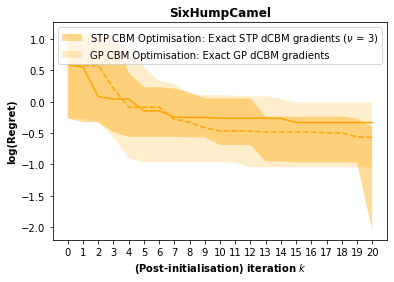

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_stp, color = 'Orange', ls='--')
plt.plot(median_gp, color = 'Orange', ls='-')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Orange', alpha=0.4, label='STP CBM Optimisation: Exact STP dCBM gradients ' r'($\nu$' ' = {})'.format(df))
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Orange', alpha=0.2, label='GP CBM Optimisation: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [99]:
time_gp, time_stp


(466.5624213218689, 522.5051748752594)

In [100]:
### acqFunc attribute x, stddev: run number = 1

acqFuncgp_gp_1 = acqFuncExact(gp_1.history)
acqFuncstp_stp_1 = acqFuncExact(stp_1.history)

e1 = np.std(acqFuncstp_stp_1)
a1 = np.std(acqFuncgp_gp_1)

e1, a1


(0.20672326144907774, 0.21610424448419685)

In [101]:
### acqFunc attribute x, stddev: run number = 2

acqFuncgp_gp_2 = acqFuncExact(gp_2.history)
acqFuncstp_stp_2 = acqFuncExact(stp_2.history)

e2 = np.std(acqFuncstp_stp_2)
a2 = np.std(acqFuncgp_gp_2)

e2, a2


(0.2621927473828091, 0.20727899803766686)

In [102]:
### acqFunc attribute x, stddev: run number = 3

acqFuncgp_gp_3 = acqFuncExact(gp_3.history)
acqFuncstp_stp_3 = acqFuncExact(stp_3.history)

e3 = np.std(acqFuncstp_stp_3)
a3 = np.std(acqFuncgp_gp_3)

e3, a3


(0.3310538723286116, 0.15129014734893614)

In [103]:
### acqFunc attribute x, stddev: run number = 4

acqFuncgp_gp_4 = acqFuncExact(gp_4.history)
acqFuncstp_stp_4 = acqFuncExact(stp_4.history)

e4 = np.std(acqFuncstp_stp_4)
a4 = np.std(acqFuncgp_gp_4)

e4, a4


(0.24656902920738252, 0.23847052136992092)

In [104]:
### acqFunc attribute x, stddev: run number = 5

acqFuncgp_gp_5 = acqFuncExact(gp_5.history)
acqFuncstp_stp_5 = acqFuncExact(stp_5.history)

e5 = np.std(acqFuncstp_stp_5)
a5 = np.std(acqFuncgp_gp_5)

e5, a5


(0.3500910214430155, 0.32671594790433023)

In [105]:
### acqFunc attribute x, stddev: run number = 6

acqFuncgp_gp_6 = acqFuncExact(gp_6.history)
acqFuncstp_stp_6 = acqFuncExact(stp_6.history)

e6 = np.std(acqFuncstp_stp_6)
a6 = np.std(acqFuncgp_gp_6)

e6, a6


(0.3059679163297963, 0.21043641162813392)

In [106]:
### acqFunc attribute x, stddev: run number = 7

acqFuncgp_gp_7 = acqFuncExact(gp_7.history)
acqFuncstp_stp_7 = acqFuncExact(stp_7.history)

e7 = np.std(acqFuncstp_stp_7)
a7 = np.std(acqFuncgp_gp_7)

e7, a7


(0.30566147040037245, 0.18332960395239634)

In [107]:
### acqFunc attribute x, stddev: run number = 8

acqFuncgp_gp_8 = acqFuncExact(gp_8.history)
acqFuncstp_stp_8 = acqFuncExact(stp_8.history)

e8 = np.std(acqFuncstp_stp_8)
a8 = np.std(acqFuncgp_gp_8)

e8, a8


(0.22468989980612633, 0.15094646760734912)

In [108]:
### acqFunc attribute x, stddev: run number = 9

acqFuncgp_gp_9 = acqFuncExact(gp_9.history)
acqFuncstp_stp_9 = acqFuncExact(stp_9.history)

e9 = np.std(acqFuncstp_stp_9)
a9 = np.std(acqFuncgp_gp_9)

e9, a9


(0.2544198928996304, 0.21176456821079803)

In [109]:
### acqFunc attribute x, stddev: run number = 10

acqFuncgp_gp_10 = acqFuncExact(gp_10.history)
acqFuncstp_stp_10 = acqFuncExact(stp_10.history)

e10 = np.std(acqFuncstp_stp_10)
a10 = np.std(acqFuncgp_gp_10)

e10, a10


(0.2648287232618204, 0.11483478946189472)

In [110]:
### acqFunc attribute x, stddev: run number = 11

acqFuncgp_gp_11 = acqFuncExact(gp_11.history)
acqFuncstp_stp_11 = acqFuncExact(stp_11.history)

e11 = np.std(acqFuncstp_stp_11)
a11 = np.std(acqFuncgp_gp_11)

e11, a11


(0.3438063370867708, 0.21372594193472294)

In [111]:
### acqFunc attribute x, stddev: run number = 12

acqFuncgp_gp_12 = acqFuncExact(gp_12.history)
acqFuncstp_stp_12 = acqFuncExact(stp_12.history)

e12 = np.std(acqFuncstp_stp_12)
a12 = np.std(acqFuncgp_gp_12)

e12, a12


(0.3799622991468253, 0.28914822174369853)

In [112]:
### acqFunc attribute x, stddev: run number = 13

acqFuncgp_gp_13 = acqFuncExact(gp_13.history)
acqFuncstp_stp_13 = acqFuncExact(stp_13.history)

e13 = np.std(acqFuncstp_stp_13)
a13 = np.std(acqFuncgp_gp_13)

e13, a13


(0.34882827690550644, 0.211833495316369)

In [113]:
### acqFunc attribute x, stddev: run number = 14

acqFuncgp_gp_14 = acqFuncExact(gp_14.history)
acqFuncstp_stp_14 = acqFuncExact(stp_14.history)

e14 = np.std(acqFuncstp_stp_14)
a14 = np.std(acqFuncgp_gp_14)

e14, a14


(0.2844447842534007, 0.13730072173033617)

In [114]:
### acqFunc attribute x, stddev: run number = 15

acqFuncgp_gp_15 = acqFuncExact(gp_15.history)
acqFuncstp_stp_15 = acqFuncExact(stp_15.history)

e15 = np.std(acqFuncstp_stp_15)
a15 = np.std(acqFuncgp_gp_15)

e15, a15


(0.43557999677161474, 0.1574957310736061)

In [115]:
### acqFunc attribute x, stddev: run number = 16

acqFuncgp_gp_16 = acqFuncExact(gp_16.history)
acqFuncstp_stp_16 = acqFuncExact(stp_16.history)

e16 = np.std(acqFuncstp_stp_16)
a16 = np.std(acqFuncgp_gp_16)

e16, a16


(0.25282073102630226, 0.4866455802145649)

In [116]:
### acqFunc attribute x, stddev: run number = 17

acqFuncgp_gp_17 = acqFuncExact(gp_17.history)
acqFuncstp_stp_17 = acqFuncExact(stp_17.history)

e17 = np.std(acqFuncstp_stp_17)
a17 = np.std(acqFuncgp_gp_17)

e17, a17


(0.3238655988573168, 0.19588198298445603)

In [117]:
### acqFunc attribute x, stddev: run number = 18

acqFuncgp_gp_18 = acqFuncExact(gp_18.history)
acqFuncstp_stp_18 = acqFuncExact(stp_18.history)

e18 = np.std(acqFuncstp_stp_18)
a18 = np.std(acqFuncgp_gp_18)

e18, a18


(0.34365396651833574, 0.13276296258567524)

In [118]:
### acqFunc attribute x, stddev: run number = 19

acqFuncgp_gp_19 = acqFuncExact(gp_19.history)
acqFuncstp_stp_19 = acqFuncExact(stp_19.history)

e19 = np.std(acqFuncstp_stp_19)
a19 = np.std(acqFuncgp_gp_19)

e19, a19


(0.3411581357487781, 0.19878852996697693)

In [119]:
### acqFunc attribute x, stddev: run number = 20

acqFuncgp_gp_20 = acqFuncExact(gp_20.history)
acqFuncstp_stp_20 = acqFuncExact(stp_20.history)

e20 = np.std(acqFuncstp_stp_20)
a20 = np.std(acqFuncgp_gp_20)

e20, a20


(0.3522261009267745, 0.19692639279508953)

In [120]:
### Summarize arrays: 

stp_stddev = np.sort([e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20])
gp_stddev = np.sort([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16,a17,a18,a19,a20])

np.mean(stp_stddev), np.mean(gp_stddev)


(0.3079272030875134, 0.21158406301755592)

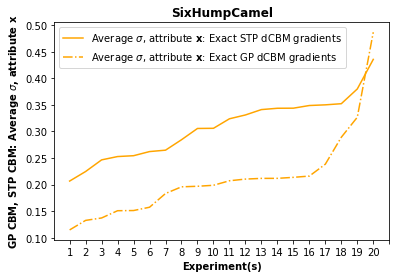

In [121]:
### Visualise!

title = func
plt.figure()

plt.plot(stp_stddev, color = 'Orange', ls='-', label='Average $\sigma$, attribute $\mathbf{x}$: Exact STP dCBM gradients')
plt.plot(gp_stddev, color = 'Orange', ls='-.', label='Average $\sigma$, attribute $\mathbf{x}$: Exact GP dCBM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('GP CBM, STP CBM: Average $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
